#### Import / Global Vars

In [92]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [93]:
#imports section
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
from mvo_utils_v2 import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [94]:
# L/S utility functions

# long-short version of recommend allocations
def ls_recommend_allocs(px, lb, net_exp, lev, min_w, max_w, gamma_val):
    px = clean_nas(px) # clean dataframe
    px_portion = px[-lb:] # subselect the period to optimize; frame and lb were duplicatives
    returns, alloc = ls_get_weights(
        px_portion, lb, net_exp, lev, min_w, max_w, gamma_val) # subselect the period to optimize
    port_perf = calc_port_performance(returns.values, alloc.values)
    pdf = pd.DataFrame(port_perf, index=returns.index, columns=["Quantum"])
    return px_portion, returns, alloc, pdf

# long-short version of optimization, position weights
def ls_get_weights(px, lb, min_sum, max_sum, min_w, max_w, gamma_val):
    lb_rets = px.sort_index().pct_change().fillna(0) # capture the last lb days going back
    n = lb_rets.shape[1]; mu = lb_rets.mean().values.T; Sigma = lb_rets.cov().values
    w = cvx.Variable(n)
    gamma = cvx.Parameter(sign='positive')
    Lmax = cvx.Parameter()
    ret = mu.T * w; risk = cvx.quad_form(w, Sigma)
    lo_obj = cvx.Maximize(ret - gamma*risk)
    ls_const = [cvx.sum_entries(w) == min_sum, cvx.norm(w, 1) < Lmax, w <= max_w, w >= min_w]
    prob = cvx.Problem(lo_obj, ls_const)
    gamma.value = gamma_val; Lmax.value = max_sum
    prob.solve()
    weights = w.value if prob.status == 'optimal' else np.zeros((n, 1))
    np_weights = np.array(weights)
    lb_weights = pd.DataFrame(np_weights.T, index=[lb_rets.index[-1]], columns=lb_rets.columns)
    return lb_rets, lb_weights

# pending implementation using partials
def quick_gamma(glist, px, lb, net_exp, lev, min_w, max_w):
    if len(glist) <= 1: 
        mid_g = glist[0]
        mid_sr = get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, mid_g)
        return mid_g, mid_sr
    else:
        mid = len(glist)//2; left = glist[:mid]; right = glist[mid:]
        mid_l = left[len(left)//2]; mid_r = right[len(right)//2]
        left_sr = get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, mid_l)
        right_sr = get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, mid_r)
        sublist = left if left_sr > right_sr else right
        #if left_sr > right_sr: sublist = left
        #else: sublist = right
        return quick_gamma(sublist, px, lb, net_exp, lev, min_w, max_w)

# return portfolio sharpe for a given optimization
def get_sr_for_opt(px, lb, net_exp, lev, min_w, max_w, gamma):
    px_p, _, alloc, pdf = ls_recommend_allocs(px, lb, net_exp, lev, min_w, max_w, gamma)
    rec = last_allocation(alloc, 0.01)
    ret, risk = port_metrics(px_p, rec)
    return ret / risk

# cleans small positions in long-short portfolios based on minimum weight criteria
def filter_ls(rec, pos_filter):
    long = rec[(rec > pos_filter).values]; short = rec[(rec < -pos_filter).values]
    return long.append(short)

#calculates the historical allocations based on a date frequency
def get_hist_allocs(rebal_freq, px, lb, g_samples, min_len, pos_filter):
    px = clean_nas(px)
    as_of_idx = px.head(1).combine_first(px.asfreq(rebal_freq)).dropna()
    hist_allocs = pd.DataFrame([], index=as_of_idx.index)
    if log: print(len(as_of_idx.index), "rebalances"); print(as_of_idx.index)
    for d in as_of_idx.index:
        subset = px.loc[:d]; days = len(subset)
        if days < min_len: continue
        gamma_val, gamma_sr = quick_gamma(gamma_vals, subset, lb, net_exposure, leverage, min_weight, max_weight)
        if log: print("rebalancing: {0}, {1:.2f}, {2:.2f}".format(d, gamma_val, gamma_sr))
        px_portion, returns, alloc, pdf = ls_recommend_allocs(
            subset, lb, net_exposure, leverage, min_weight, max_weight, gamma_val)
        rec = last_allocation(alloc, min_weight)
        l_s = filter_ls(rec, pos_filter)
        hist_allocs = hist_allocs.combine_first(alloc[l_s.index])
    return hist_allocs

# alings allocations with trading days
def align_ret_allocs(allocs, px):
    rets = px[allocs.columns].pct_change().fillna(0)
    resampled_alloc = allocs.resample('D').pad()
    resampled_alloc = resampled_alloc.loc[rets.index]
    return rets, resampled_alloc

# explicit function to review global vars
def print_global_vars():
    global_vars_fmt = "Global Variables\n" \
    "Refresh Pricing: {}\n" + "Historical Time Window: {}\n" + "Lookback: {}\n" \
    + "Rebalance Frequency: {}\n" + "Net Exposure: {}\n" \
    + "Leverage: {}\n" + "Weights: min {} to max {}\n" + "Universe: {}\n"
    print(global_vars_fmt.format(
        refresh_pricing, hist_window, lookback, 
        rebal_frequency, net_exposure, 
        leverage, min_weight, max_weight,
        universe))

# summary plots
def plot_bt_summary(df):
    pct_chg_df = df.pct_change()
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,3), dpi=300)
    compound(df).plot(ax=ax1, x_compat=True)
    ax1.yaxis.set_label('Indexed Return')
    pct_chg_df.plot.hist(ax=ax2, stacked=True, bins=20)
    pct_chg_df.boxplot(ax=ax3)
    pct_chg_df.plot.kde(ax=ax4)
    print(pct_chg_df.describe().applymap(short_float))
    
# create portfolio risk metric matrix for net exposure selection
TS_METRICS_LEGEND = ['Return', 'Risk', 'RSpread', 'Sharpe', 'MaxDraw']
def ts_metrics(pdf):
    timespan = len(pdf.index)
    ret = (pdf.pct_change().mean() * timespan)
    std = (pdf.pct_change().std() * sqrt(timespan))
    mdd = max_drawdown(pdf)[0];
    
    return ret, std, ret - std, ret / std, mdd

# calculates max drawdown, largest reduction from highest point
def max_drawdown(xs):
    i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
    j = np.argmax(xs[:i]) # start of period
    pct_mdd = -1 * ((xs[j] - xs[i]) / xs[j])
    return pct_mdd, j, i

# plots max drawdown chart
def plot_max_drawdown(xs):
    _, j, i = max_drawdown(xs)
    plt.plot(xs)
    plt.legend()
    plt.plot([i, j], [xs[i], xs[j]], 'o', color='Red', markersize=5)

In [95]:
# Global variables
log = True
refresh_pricing = False
universe = 'spy-sectors'  # 'spy_sectors OR 'ark_etfs'
active_etf = None  # ETF name OR None for broad market

#variables for performance analysis
lookback = 60
net_exposure = 0
leverage = 1
min_weight = -0.05
max_weight = 0.05  # default optimization vars
min_len = 3
pos_filter = 0.01  # cleaning variables
rebal_frequency = 'W-' + datetime.now().strftime('%a')  # for historical allocations
gamma_vals = np.logspace(-1, 3, num=25)  # 1 to 1000 range

net_exposures = np.arange(0.0, 1.01, 0.2)
left_substr = lambda a, i: [str(c)[:i] for c in a.columns.tolist()]
BACKTEST_PATH = './backtests/'
RECOMMENDATION_PATH = './recommendations/'
FNAME_INDEX = "{}backtest-{}-{}.csv"
FNAME_GEN = "{}{}-{}-{}-{}.csv"

print_global_vars()

Global Variables
Refresh Pricing: False
Historical Time Window: 100
Lookback: 60
Rebalance Frequency: W-Wed
Net Exposure: 0
Leverage: 1
Weights: min -0.05 to max 0.05
Universe: spy-sectors



#### Load sector components from hard-drive

In [96]:
# load spy sector components
# would be nice to load a JSON with configuration
ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy-sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE'],
    'ark-etfs': ['ARKG', 'ARKK', 'ARKQ', 'ARKW']
}

config = {
    'spy-sectors' : {
        'hold_cols': ['Symbol','Company Name', 'Index Weight'],
        'hold_format': r'holdings-spy-',
        'idx_col': 'Symbol',
        'fname': 'spy-sectors',
        'skiprows': 1
    },
    'ark-etfs' : {
        'hold_cols': ['ticker','company', 'weight(%)'],
        'hold_format': r'holdings-ark-',
        'idx_col': 'ticker',
        'fname': 'ark-etfs',
        'skiprows': 0
    }
}

hold_cols = config[universe]['hold_cols']
hold_format = config[universe]['hold_format']
idx_col = config[universe]['idx_col']
fname = config[universe]['fname']
skiprows = config[universe]['skiprows']

companies = load_components(
    companies, hold_format, hold_cols, 
    idx_col, ticker_map[universe], srows=skiprows)
print("Companies loaded:", companies.shape)
px_etfs = load_pricing(fname + '.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

Companies loaded: (505, 3)
Loaded pricing for spy-sectors.csv, with shape (69, 10)
Loaded pricing for SPY.csv, with shape (69, 1)


In [97]:
# Load pricing for components of each sectors
px_etfs = load_pricing(universe + '.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')
consol_px = clean_nas(load_consol_px(ticker_map, universe))
if(active_etf != None): companies = companies[companies['ETF']==active_etf] # filter by selected ETF
tickers = companies.index.tolist()
tickers=[i for i in tickers if i not in ['BF.b','BRK.b']] ## esta es una correcion extra para no incluir 'BF.b','BRK.b'
consol_px = consol_px[list(set(tickers))]

Loaded pricing for spy-sectors.csv, with shape (69, 10)
Loaded pricing for SPY.csv, with shape (69, 1)
Loaded pricing for XLE-hold-pricing.csv, with shape (2605, 31)
Loaded pricing for XLU-hold-pricing.csv, with shape (2605, 28)
Loaded pricing for XLK-hold-pricing.csv, with shape (2605, 73)
Loaded pricing for XLB-hold-pricing.csv, with shape (2605, 25)
Loaded pricing for XLP-hold-pricing.csv, with shape (2605, 34)
Loaded pricing for XLY-hold-pricing.csv, with shape (2605, 82)
Loaded pricing for XLI-hold-pricing.csv, with shape (2605, 70)
Loaded pricing for XLV-hold-pricing.csv, with shape (2605, 61)
Loaded pricing for XLF-hold-pricing.csv, with shape (2605, 68)
Loaded pricing for XLRE-hold-pricing.csv, with shape (2605, 33)


In [98]:
# Removing tickers for M&A targets and diff class shares of same co.
remove_tickers = ['CSRA', 'DPS', 'UAA', 'DISCK', 'JUNO', 'XL', 'WELL', 'BKNG', 'SNI','EVGN', 'CBRE']
remove = list(set(remove_tickers).intersection(consol_px.columns.tolist()))
if len(remove) > 0: consol_px.drop(remove, axis=1, inplace=True)
consol_px.shape
consol_px = consol_px[sorted(consol_px.columns.tolist())]
consol_px.to_csv("consol_algo.csv")
consol_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2605 entries, 2007-11-16 to 2018-03-23
Columns: 495 entries, A to ZTS
dtypes: float64(495)
memory usage: 9.9 MB


#### Key analysis questions to answer
Backtests: search for optimal drivers
1. make sure the date periods are correct
2. plot gamma values and risk, what's the relationship? 
3. what are the net exposures with weekly rebalance during 2018?
4. what are the net exposures with quarterly, monthly, and weekly rebalances?
5. how does the optimal net exposure behave over time, 10 years, does it change over time?
6. does it get better with wider weights?
7. does it get better with longer lookbacks?

In [99]:
# 1. make sure the date periods are correct
log = True
time_frame = '2017-Q3'; rebal_frequency = 'W-WED'
subset = consol_px[time_frame]
subset.head(1).combine_first(subset.asfreq(rebal_frequency)).dropna()

as_of_idx = subset.head(1).combine_first(subset.asfreq(rebal_frequency)).dropna()
for d in as_of_idx.index: print(d, subset.loc[:d].shape)

2017-07-03 00:00:00 (1, 495)
2017-07-05 00:00:00 (2, 495)
2017-07-12 00:00:00 (7, 495)
2017-07-19 00:00:00 (12, 495)
2017-07-26 00:00:00 (17, 495)
2017-08-02 00:00:00 (22, 495)
2017-08-09 00:00:00 (27, 495)
2017-08-16 00:00:00 (32, 495)
2017-08-23 00:00:00 (37, 495)
2017-08-30 00:00:00 (42, 495)
2017-09-06 00:00:00 (46, 495)
2017-09-13 00:00:00 (51, 495)
2017-09-20 00:00:00 (56, 495)
2017-09-27 00:00:00 (61, 495)


In [20]:
# 2. plot gamma values and risk, what's the relationship? 
log = False
time_frame = '2017-Q3'
subset = consol_px[time_frame];
subset.drop(['BHF'], axis=1, inplace=True);
net_exposure = 1

cols = ['gamma','Risk','Return','SR','MDD']
gamma_chart = pd.DataFrame([], columns=cols)

def compute_gammas():
    for i in gamma_vals:
        px_portion, returns, alloc, pdf = ls_recommend_allocs(
            subset, lookback, net_exposure, leverage, min_weight, max_weight, i)
        rec = last_allocation(alloc, min_weight)
        l_s = filter_ls(rec, pos_filter)
        ret, risk = port_metrics(subset, l_s)
        mdd, _, _ = max_drawdown(pdf.values)
        gamma_chart.loc[i,gamma_chart.columns] = (i, risk, ret, ret / risk, mdd)
    return gamma_chart.astype(np.float)

%time compute_gammas().describe()

/Users/vicveiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


CPU times: user 7.74 s, sys: 556 ms, total: 8.3 s
Wall time: 4.22 s


,gamma,Risk,Return,SR,MDD
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,125.498210,0.047620,0.194223,4.212197,-0.016278
std,247.696034,0.017138,0.056148,0.508408,0.008114
min,0.100000,0.017265,0.068200,3.661707,-0.027910
25%,1.000000,0.031984,0.161081,3.805208,-0.024068
50%,10.000000,0.054699,0.226823,3.980483,-0.012157
75%,100.000000,0.062282,0.236007,4.691495,-0.009665
max,1000.000000,0.064427,0.237692,5.094166,-0.007031


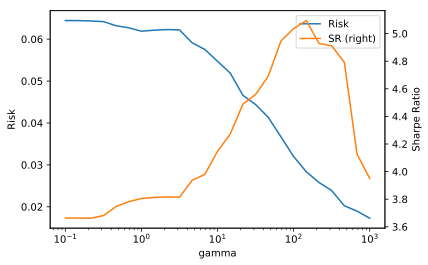

In [21]:
ax = gamma_chart[['gamma','Risk','SR']].plot(x=['gamma'], secondary_y=['SR'], logx=True)
ax.set_ylabel('Risk')
ax.right_ax.set_ylabel('Sharpe Ratio');

          0.0     0.2     0.4     0.6     0.8     1.0
count  60.000  60.000  60.000  60.000  60.000  60.000
mean    0.003   0.002   0.001   0.001   0.002   0.001
std     0.006   0.006   0.006   0.007   0.009   0.011
min    -0.007  -0.013  -0.023  -0.026  -0.029  -0.035
25%    -0.001  -0.001  -0.000  -0.002  -0.002  -0.003
50%     0.000   0.000   0.000   0.002   0.003   0.002
75%     0.006   0.004   0.005   0.006   0.006   0.006
max     0.024   0.021   0.014   0.017   0.020   0.024


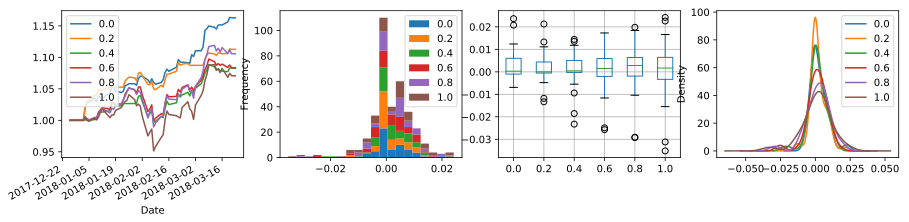

In [34]:
# 3. what is the optimal net exposure, weekly rebalance during 2018?
time_frame = '2017-12-25'; rebal_frequency = 'W-WED'
subset = consol_px[time_frame:]
fname = FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency)

try:
    net_exp_port = pd.read_csv(fname, index_col='Date', parse_dates=True)
    net_exp_port.columns = left_substr(net_exp_port, 3)
    plot_bt_summary(net_exp_port)
    # conclusion: see that the net exposure equal to zero acheives the best return with the smallest drawdown
    
except Exception as err:
    print("Error: {0}, please run backtest below".format(err))
    # this will take a while
    net_exp_portfolios = pd.DataFrame([])
    log = True
    for ne in net_exposures:
        net_exposure = ne
        hist_allocs = get_hist_allocs(rebal_frequency, subset, lookback, gamma_vals, min_len, pos_filter)
        returns, allocs = align_ret_allocs(hist_allocs, subset)
        time_series = calc_port_performance(returns, allocs).to_frame()
        time_series.columns = [ne]
        net_exp_portfolios = net_exp_portfolios.combine_first(time_series.copy())
        returns.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'returns', ne, time_frame, rebal_frequency))
        allocs.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'allocs', ne, time_frame, rebal_frequency))
    net_exp_portfolios.to_csv(FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency))

In [81]:
# creates portfolio risk metric matrix to determine best net exposure
port_risk_matrix = lambda x: pd.Series([x for x in ts_metrics(x)], index=TS_METRICS_LEGEND)
risk_matrix = net_exp_port.apply(port_risk_matrix)
risk_matrix
net_exposure = float(risk_matrix.loc['RSpread'].argmax())
net_exposure

/Users/vicveiga/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/Users/vicveiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  """


0.0

            0.0       0.2       0.4       0.6       0.8       1.0
count  2578.000  2578.000  2578.000  2578.000  2578.000  2578.000
mean      0.000     0.000     0.000     0.000     0.001     0.000
std       0.010     0.009     0.008     0.008     0.013     0.006
min      -0.110    -0.098    -0.082    -0.085    -0.045    -0.036
25%      -0.003    -0.003    -0.003    -0.003    -0.002    -0.002
50%       0.000     0.000     0.000     0.000     0.000     0.000
75%       0.004     0.004     0.004     0.004     0.003     0.003
max       0.065     0.053     0.051     0.048     0.547     0.046


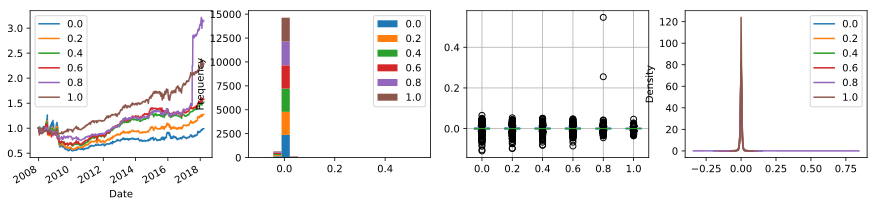

In [30]:
# 4. what are the net exposures with monthly rebalances?
time_frame = '2007-12-25'; rebal_frequency = 'BM'
subset = consol_px[time_frame:]
fname = FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency)

try:
    net_exp_port = pd.read_csv(fname, index_col='Date', parse_dates=True)
    net_exp_port.columns = left_substr(net_exp_port, 3)
    plot_bt_summary(net_exp_port)
    # conclusion: slow rebalances underperforms the benchmark, too slow to adapt

except Exception as err:
    print("Error: {0}, please run backtest below".format(err))
    # this will take a while
    log = True
    net_exp_portfolios = pd.DataFrame([])
    for ne in net_exposures:
        net_exposure = ne
        hist_allocs = get_hist_allocs(rebal_frequency, subset, lookback, gamma_vals, min_len, pos_filter)
        returns, allocs = align_ret_allocs(hist_allocs, subset)
        time_series = calc_port_performance(returns, allocs).to_frame()
        time_series.columns = [ne]
        net_exp_portfolios = net_exp_portfolios.combine_first(time_series.copy())
        returns.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'returns', ne, time_frame, rebal_frequency))
        allocs.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'allocs', ne, time_frame, rebal_frequency))
    net_exp_portfolios.to_csv(FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency))

            0.0       0.2       0.4       0.6       0.8       1.0
count  2578.000  2578.000  2578.000  2578.000  2578.000  2578.000
mean     -0.000     0.000     0.000     0.000     0.000     0.000
std       0.009     0.008     0.007     0.008     0.014     0.006
min      -0.104    -0.097    -0.082    -0.085    -0.046    -0.041
25%      -0.003    -0.003    -0.003    -0.003    -0.003    -0.002
50%       0.000     0.000     0.000     0.000     0.000     0.000
75%       0.003     0.003     0.004     0.004     0.003     0.003
max       0.058     0.044     0.042     0.051     0.547     0.047


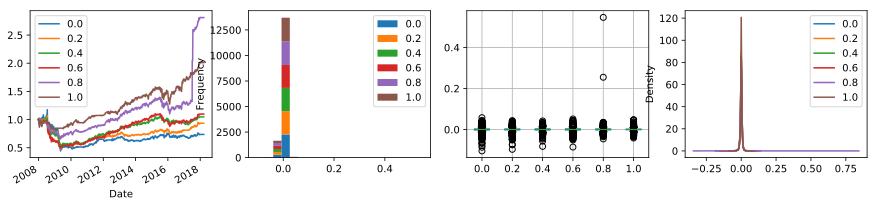

In [31]:
# 4. what are the net exposures with quarterly rebalances?
time_frame = '2007-12-25'; rebal_frequency = 'BQ'
subset = consol_px[time_frame:]
fname = FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency)

try:
    net_exp_port = pd.read_csv(fname, index_col='Date', parse_dates=True)
    net_exp_port.columns = left_substr(net_exp_port, 3)
    plot_bt_summary(net_exp_port)
    # conclusion: slow rebalances underperforms the benchmark, too slow to adapt

except Exception as err:
    print("Error: {0}, please run backtest below".format(err))
    # this will take a while
    log = True
    net_exp_portfolios = pd.DataFrame([])
    for ne in net_exposures:
        net_exposure = ne
        hist_allocs = get_hist_allocs(rebal_frequency, subset, lookback, gamma_vals, min_len, pos_filter)
        returns, allocs = align_ret_allocs(hist_allocs, subset)
        time_series = calc_port_performance(returns, allocs).to_frame()
        time_series.columns = [ne]
        net_exp_portfolios = net_exp_portfolios.combine_first(time_series.copy())
        returns.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'returns', ne, time_frame, rebal_frequency))
        allocs.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'allocs', ne, time_frame, rebal_frequency))
    net_exp_portfolios.to_csv(FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency))

In [100]:
# 4. what are the net exposures with weekly rebalances?
log = True
time_frame = '2007-12-25'; rebal_frequency = 'W-WED'
subset = consol_px[time_frame:]
fname = FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency)

try:
    net_exp_port = pd.read_csv(fname, index_col='Date', parse_dates=True)
    net_exp_port.columns = left_substr(net_exp_port, 3)
    plot_bt_summary(net_exp_port)
    # conclusion: see that the 0 net exposure acheives the best "cumulative" returns
    # however, there are a fair amount of outliers in the boxplot
    # need to decompose into years to understand the behaviour

except Exception as err:
    print("Error: {0}, please run backtest below".format(err))
    # this will take a while
    log = True
    net_exp_portfolios = pd.DataFrame([])
    for ne in net_exposures:
        net_exposure = ne
        hist_allocs = get_hist_allocs(rebal_frequency, subset, lookback, gamma_vals, min_len, pos_filter)
        returns, allocs = align_ret_allocs(hist_allocs, subset)
        time_series = calc_port_performance(returns, allocs).to_frame()
        time_series.columns = [ne]
        net_exp_portfolios = net_exp_portfolios.combine_first(time_series.copy())
        returns.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'returns', ne, time_frame, rebal_frequency))
        allocs.to_csv(FNAME_GEN.format(BACKTEST_PATH, 'allocs', ne, time_frame, rebal_frequency))
    net_exp_portfolios.to_csv(FNAME_INDEX.format(BACKTEST_PATH, time_frame, rebal_frequency))

Error: File b'./backtests/backtest-2007-12-25-W-WED.csv' does not exist, please run backtest below
532 rebalances
DatetimeIndex(['2007-12-26', '2008-01-02', '2008-01-09', '2008-01-16',
               '2008-01-23', '2008-01-30', '2008-02-06', '2008-02-13',
               '2008-02-20', '2008-02-27',
               ...
               '2018-01-17', '2018-01-24', '2018-01-31', '2018-02-07',
               '2018-02-14', '2018-02-21', '2018-02-28', '2018-03-07',
               '2018-03-14', '2018-03-21'],
              dtype='datetime64[ns]', name='Date', length=532, freq=None)
rebalancing: 2008-01-02 00:00:00, 6.81, 1.77
rebalancing: 2008-01-09 00:00:00, 1.00, 1.57
rebalancing: 2008-01-16 00:00:00, 0.68, 1.59
rebalancing: 2008-01-23 00:00:00, 10.00, 1.19
rebalancing: 2008-01-30 00:00:00, 10.00, 1.49
rebalancing: 2008-02-06 00:00:00, 10.00, 1.29
rebalancing: 2008-02-13 00:00:00, 21.54, 1.66


/Users/vicveiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


rebalancing: 2008-02-20 00:00:00, 21.54, 1.68
rebalancing: 2008-02-27 00:00:00, 21.54, 1.77
rebalancing: 2008-03-05 00:00:00, 6.81, 1.69
rebalancing: 2008-03-12 00:00:00, 6.81, 1.56
rebalancing: 2008-03-19 00:00:00, 6.81, 1.41
rebalancing: 2008-03-26 00:00:00, 2.15, 1.92
rebalancing: 2008-04-02 00:00:00, 21.54, 2.26
rebalancing: 2008-04-09 00:00:00, 100.00, 2.25
rebalancing: 2008-04-16 00:00:00, 31.62, 3.19
rebalancing: 2008-04-23 00:00:00, 10.00, 2.59
rebalancing: 2008-04-30 00:00:00, 6.81, 3.13
rebalancing: 2008-05-07 00:00:00, 3.16, 3.26
rebalancing: 2008-05-14 00:00:00, 0.32, 3.01
rebalancing: 2008-05-21 00:00:00, 4.64, 2.84
rebalancing: 2008-05-28 00:00:00, 0.32, 2.99
rebalancing: 2008-06-04 00:00:00, 0.32, 3.56
rebalancing: 2008-06-11 00:00:00, 6.81, 3.60
rebalancing: 2008-06-18 00:00:00, 6.81, 4.17
rebalancing: 2008-06-25 00:00:00, 2.15, 3.43
rebalancing: 2008-07-02 00:00:00, 10.00, 2.85
rebalancing: 2008-07-09 00:00:00, 2.15, 2.49
rebalancing: 2008-07-16 00:00:00, 0.32, 2.57
re

rebalancing: 2011-07-27 00:00:00, 100.00, 2.04
rebalancing: 2011-08-03 00:00:00, 6.81, 1.80
rebalancing: 2011-08-10 00:00:00, 3.16, 0.75
rebalancing: 2011-08-17 00:00:00, 4.64, 1.01
rebalancing: 2011-08-24 00:00:00, 0.15, 0.90
rebalancing: 2011-08-31 00:00:00, 10.00, 1.00
rebalancing: 2011-09-07 00:00:00, 0.68, 1.29
rebalancing: 2011-09-14 00:00:00, 0.15, 1.27
rebalancing: 2011-09-21 00:00:00, 0.10, 1.36
rebalancing: 2011-09-28 00:00:00, 0.22, 0.95
rebalancing: 2011-10-05 00:00:00, 0.68, 0.83
rebalancing: 2011-10-12 00:00:00, 0.10, 0.93
rebalancing: 2011-10-19 00:00:00, 0.68, 1.04
rebalancing: 2011-10-26 00:00:00, 0.10, 1.08
rebalancing: 2011-11-02 00:00:00, 0.32, 1.77
rebalancing: 2011-11-09 00:00:00, 6.81, 1.44
rebalancing: 2011-11-16 00:00:00, 68.13, 1.87
rebalancing: 2011-11-23 00:00:00, 0.15, 1.21
rebalancing: 2011-11-30 00:00:00, 68.13, 1.64
rebalancing: 2011-12-07 00:00:00, 1.00, 1.59
rebalancing: 2011-12-14 00:00:00, 46.42, 1.57
rebalancing: 2011-12-21 00:00:00, 46.42, 1.90
reb

rebalancing: 2015-01-21 00:00:00, 6.81, 3.34
rebalancing: 2015-01-28 00:00:00, 3.16, 3.49
rebalancing: 2015-02-04 00:00:00, 2.15, 3.75
rebalancing: 2015-02-11 00:00:00, 0.22, 3.77
rebalancing: 2015-02-18 00:00:00, 4.64, 3.23
rebalancing: 2015-02-25 00:00:00, 1.00, 3.00
rebalancing: 2015-03-04 00:00:00, 0.15, 3.04
rebalancing: 2015-03-11 00:00:00, 215.44, 3.42
rebalancing: 2015-03-18 00:00:00, 215.44, nan
rebalancing: 2015-03-25 00:00:00, 68.13, 2.83
rebalancing: 2015-04-01 00:00:00, 68.13, 3.74
rebalancing: 2015-04-08 00:00:00, 14.68, 3.74
rebalancing: 2015-04-15 00:00:00, 146.78, 3.96
rebalancing: 2015-04-22 00:00:00, 31.62, 3.66
rebalancing: 2015-04-29 00:00:00, 46.42, 3.35
rebalancing: 2015-05-06 00:00:00, 215.44, 2.96
rebalancing: 2015-05-13 00:00:00, 68.13, 2.89
rebalancing: 2015-05-20 00:00:00, 100.00, 2.74
rebalancing: 2015-05-27 00:00:00, 68.13, 2.95
rebalancing: 2015-06-03 00:00:00, 68.13, 4.23
rebalancing: 2015-06-10 00:00:00, 10.00, 4.27
rebalancing: 2015-06-17 00:00:00, 3.1

/Users/vicveiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


532 rebalances
DatetimeIndex(['2007-12-26', '2008-01-02', '2008-01-09', '2008-01-16',
               '2008-01-23', '2008-01-30', '2008-02-06', '2008-02-13',
               '2008-02-20', '2008-02-27',
               ...
               '2018-01-17', '2018-01-24', '2018-01-31', '2018-02-07',
               '2018-02-14', '2018-02-21', '2018-02-28', '2018-03-07',
               '2018-03-14', '2018-03-21'],
              dtype='datetime64[ns]', name='Date', length=532, freq=None)
rebalancing: 2008-01-02 00:00:00, 1000.00, 3.41
rebalancing: 2008-01-09 00:00:00, 3.16, 1.64
rebalancing: 2008-01-16 00:00:00, 6.81, 1.44
rebalancing: 2008-01-23 00:00:00, 10.00, 1.29
rebalancing: 2008-01-30 00:00:00, 46.42, 1.54
rebalancing: 2008-02-06 00:00:00, 21.54, 1.36
rebalancing: 2008-02-13 00:00:00, 464.16, 1.46
rebalancing: 2008-02-20 00:00:00, 31.62, 1.74
rebalancing: 2008-02-27 00:00:00, 31.62, 1.86
rebalancing: 2008-03-05 00:00:00, 31.62, 1.81
rebalancing: 2008-03-12 00:00:00, 14.68, 1.63
rebalancing: 2

rebalancing: 2011-03-30 00:00:00, 100.00, 4.25
rebalancing: 2011-04-06 00:00:00, 68.13, 4.38
rebalancing: 2011-04-13 00:00:00, 68.13, 4.28
rebalancing: 2011-04-20 00:00:00, 68.13, 4.35
rebalancing: 2011-04-27 00:00:00, 100.00, 5.48
rebalancing: 2011-05-04 00:00:00, 316.23, 4.45
rebalancing: 2011-05-11 00:00:00, 215.44, nan
rebalancing: 2011-05-18 00:00:00, 316.23, 4.59
rebalancing: 2011-05-25 00:00:00, 100.00, 4.80
rebalancing: 2011-06-01 00:00:00, 46.42, 4.28
rebalancing: 2011-06-08 00:00:00, 68.13, 3.88
rebalancing: 2011-06-15 00:00:00, 68.13, 3.20
rebalancing: 2011-06-22 00:00:00, 31.62, 3.05
rebalancing: 2011-06-29 00:00:00, 68.13, 2.88
rebalancing: 2011-07-06 00:00:00, 68.13, 3.31
rebalancing: 2011-07-13 00:00:00, 215.44, 2.95
rebalancing: 2011-07-20 00:00:00, 215.44, 2.52
rebalancing: 2011-07-27 00:00:00, 31.62, 2.05
rebalancing: 2011-08-03 00:00:00, 10.00, 1.81
rebalancing: 2011-08-10 00:00:00, 6.81, nan
rebalancing: 2011-08-17 00:00:00, 6.81, 0.99
rebalancing: 2011-08-24 00:00:

rebalancing: 2014-09-10 00:00:00, 100.00, 4.44
rebalancing: 2014-09-17 00:00:00, 215.44, 4.26
rebalancing: 2014-09-24 00:00:00, 100.00, 3.82
rebalancing: 2014-10-01 00:00:00, 46.42, 3.16
rebalancing: 2014-10-08 00:00:00, 31.62, 3.50
rebalancing: 2014-10-15 00:00:00, 6.81, 2.47
rebalancing: 2014-10-22 00:00:00, 31.62, 2.57
rebalancing: 2014-10-29 00:00:00, 68.13, 3.23
rebalancing: 2014-11-05 00:00:00, 464.16, 2.94
rebalancing: 2014-11-12 00:00:00, 31.62, 3.14
rebalancing: 2014-11-19 00:00:00, 21.54, nan
rebalancing: 2014-11-26 00:00:00, 68.13, 3.35
rebalancing: 2014-12-03 00:00:00, 31.62, 3.21
rebalancing: 2014-12-10 00:00:00, 68.13, 2.89
rebalancing: 2014-12-17 00:00:00, 46.42, 2.89
rebalancing: 2014-12-24 00:00:00, 100.00, 3.07
rebalancing: 2014-12-31 00:00:00, 31.62, 3.60
rebalancing: 2015-01-07 00:00:00, 31.62, 4.64
rebalancing: 2015-01-14 00:00:00, 6.81, nan
rebalancing: 2015-01-21 00:00:00, 10.00, 3.52
rebalancing: 2015-01-28 00:00:00, 6.81, 3.61
rebalancing: 2015-02-04 00:00:00, 

rebalancing: 2018-02-07 00:00:00, 68.13, 4.62
rebalancing: 2018-02-14 00:00:00, 68.13, 3.99
rebalancing: 2018-02-21 00:00:00, 31.62, 3.55
rebalancing: 2018-02-28 00:00:00, 68.13, 3.22
rebalancing: 2018-03-07 00:00:00, 68.13, 3.36
rebalancing: 2018-03-14 00:00:00, 68.13, 3.29
rebalancing: 2018-03-21 00:00:00, 68.13, 3.34
532 rebalances
DatetimeIndex(['2007-12-26', '2008-01-02', '2008-01-09', '2008-01-16',
               '2008-01-23', '2008-01-30', '2008-02-06', '2008-02-13',
               '2008-02-20', '2008-02-27',
               ...
               '2018-01-17', '2018-01-24', '2018-01-31', '2018-02-07',
               '2018-02-14', '2018-02-21', '2018-02-28', '2018-03-07',
               '2018-03-14', '2018-03-21'],
              dtype='datetime64[ns]', name='Date', length=532, freq=None)
rebalancing: 2008-01-02 00:00:00, 21.54, 2.24
rebalancing: 2008-01-09 00:00:00, 6.81, 1.65
rebalancing: 2008-01-16 00:00:00, 31.62, 1.71
rebalancing: 2008-01-23 00:00:00, 100.00, 1.42
rebalancing: 20

rebalancing: 2011-02-02 00:00:00, 146.78, 4.51
rebalancing: 2011-02-09 00:00:00, 146.78, 5.14
rebalancing: 2011-02-16 00:00:00, 316.23, 5.93
rebalancing: 2011-02-23 00:00:00, 100.00, 4.99
rebalancing: 2011-03-02 00:00:00, 1000.00, 5.01
rebalancing: 2011-03-09 00:00:00, 1000.00, nan
rebalancing: 2011-03-16 00:00:00, 68.13, 3.65
rebalancing: 2011-03-23 00:00:00, 100.00, 4.52
rebalancing: 2011-03-30 00:00:00, 215.44, nan
rebalancing: 2011-04-06 00:00:00, 316.23, 4.85
rebalancing: 2011-04-13 00:00:00, 100.00, 4.77
rebalancing: 2011-04-20 00:00:00, 68.13, 4.92
rebalancing: 2011-04-27 00:00:00, 215.44, 6.03
rebalancing: 2011-05-04 00:00:00, 464.16, 4.92
rebalancing: 2011-05-11 00:00:00, 100.00, 4.69
rebalancing: 2011-05-18 00:00:00, 100.00, 5.42
rebalancing: 2011-05-25 00:00:00, 100.00, 5.23
rebalancing: 2011-06-01 00:00:00, 100.00, 4.50
rebalancing: 2011-06-08 00:00:00, 215.44, 3.96
rebalancing: 2011-06-15 00:00:00, 68.13, 3.33
rebalancing: 2011-06-22 00:00:00, 68.13, 3.36
rebalancing: 2011

rebalancing: 2014-07-16 00:00:00, 215.44, 6.38
rebalancing: 2014-07-23 00:00:00, 215.44, 6.35
rebalancing: 2014-07-30 00:00:00, 1000.00, 6.37
rebalancing: 2014-08-06 00:00:00, 681.29, 4.60
rebalancing: 2014-08-13 00:00:00, 215.44, 5.21
rebalancing: 2014-08-20 00:00:00, 1000.00, nan
rebalancing: 2014-08-27 00:00:00, 215.44, 4.94
rebalancing: 2014-09-03 00:00:00, 146.78, 5.20
rebalancing: 2014-09-10 00:00:00, 1000.00, 4.95
rebalancing: 2014-09-17 00:00:00, 1000.00, 4.95
rebalancing: 2014-09-24 00:00:00, 464.16, 4.09
rebalancing: 2014-10-01 00:00:00, 100.00, 3.30
rebalancing: 2014-10-08 00:00:00, 68.13, 3.69
rebalancing: 2014-10-15 00:00:00, 6.81, nan
rebalancing: 2014-10-22 00:00:00, 100.00, 2.75
rebalancing: 2014-10-29 00:00:00, 68.13, 3.61
rebalancing: 2014-11-05 00:00:00, 68.13, 3.69
rebalancing: 2014-11-12 00:00:00, 68.13, 3.41
rebalancing: 2014-11-19 00:00:00, 68.13, 3.28
rebalancing: 2014-11-26 00:00:00, 46.42, 3.74
rebalancing: 2014-12-03 00:00:00, 215.44, 3.53
rebalancing: 2014-1

rebalancing: 2017-12-06 00:00:00, 681.29, 8.47
rebalancing: 2017-12-13 00:00:00, 316.23, 9.44
rebalancing: 2017-12-20 00:00:00, 316.23, 8.02
rebalancing: 2017-12-27 00:00:00, 215.44, 7.73
rebalancing: 2018-01-03 00:00:00, 215.44, 7.86
rebalancing: 2018-01-10 00:00:00, 215.44, 8.62
rebalancing: 2018-01-17 00:00:00, 215.44, 8.07
rebalancing: 2018-01-24 00:00:00, 464.16, 8.51
rebalancing: 2018-01-31 00:00:00, 215.44, 7.99
rebalancing: 2018-02-07 00:00:00, 68.13, 4.77
rebalancing: 2018-02-14 00:00:00, 464.16, 3.12
rebalancing: 2018-02-21 00:00:00, 31.62, 3.60
rebalancing: 2018-02-28 00:00:00, 100.00, 3.22
rebalancing: 2018-03-07 00:00:00, 68.13, 3.43
rebalancing: 2018-03-14 00:00:00, 68.13, 3.33
rebalancing: 2018-03-21 00:00:00, 46.42, 3.35
532 rebalances
DatetimeIndex(['2007-12-26', '2008-01-02', '2008-01-09', '2008-01-16',
               '2008-01-23', '2008-01-30', '2008-02-06', '2008-02-13',
               '2008-02-20', '2008-02-27',
               ...
               '2018-01-17', '2018

rebalancing: 2010-12-01 00:00:00, 100.00, 5.13
rebalancing: 2010-12-08 00:00:00, 68.13, 4.83
rebalancing: 2010-12-15 00:00:00, 100.00, 4.67
rebalancing: 2010-12-22 00:00:00, 464.16, 4.76
rebalancing: 2010-12-29 00:00:00, 146.78, 4.92
rebalancing: 2011-01-05 00:00:00, 215.44, 5.29
rebalancing: 2011-01-12 00:00:00, 215.44, 5.96
rebalancing: 2011-01-19 00:00:00, 215.44, 5.53
rebalancing: 2011-01-26 00:00:00, 146.78, 5.53
rebalancing: 2011-02-02 00:00:00, 1000.00, nan
rebalancing: 2011-02-09 00:00:00, 146.78, 5.86
rebalancing: 2011-02-16 00:00:00, 316.23, 6.43
rebalancing: 2011-02-23 00:00:00, 215.44, 5.87
rebalancing: 2011-03-02 00:00:00, 464.16, 6.73
rebalancing: 2011-03-09 00:00:00, 316.23, 5.94
rebalancing: 2011-03-16 00:00:00, 100.00, 4.08
rebalancing: 2011-03-23 00:00:00, 215.44, 4.90
rebalancing: 2011-03-30 00:00:00, 215.44, 5.43
rebalancing: 2011-04-06 00:00:00, 215.44, 5.72
rebalancing: 2011-04-13 00:00:00, 100.00, 5.21
rebalancing: 2011-04-20 00:00:00, 146.78, 5.32
rebalancing: 2

rebalancing: 2014-05-07 00:00:00, 146.78, 5.07
rebalancing: 2014-05-14 00:00:00, 215.44, 4.62
rebalancing: 2014-05-21 00:00:00, 68.13, 4.42
rebalancing: 2014-05-28 00:00:00, 100.00, 4.61
rebalancing: 2014-06-04 00:00:00, 100.00, 5.13
rebalancing: 2014-06-11 00:00:00, 100.00, 5.65
rebalancing: 2014-06-18 00:00:00, 100.00, 5.85
rebalancing: 2014-06-25 00:00:00, 146.78, 5.65
rebalancing: 2014-07-02 00:00:00, 215.44, 7.06
rebalancing: 2014-07-09 00:00:00, 464.16, 8.75
rebalancing: 2014-07-16 00:00:00, 464.16, 7.10
rebalancing: 2014-07-23 00:00:00, 215.44, 7.07
rebalancing: 2014-07-30 00:00:00, 1000.00, 7.24
rebalancing: 2014-08-06 00:00:00, 215.44, 5.06
rebalancing: 2014-08-13 00:00:00, 316.23, 5.76
rebalancing: 2014-08-20 00:00:00, 464.16, 5.90
rebalancing: 2014-08-27 00:00:00, 215.44, 5.50
rebalancing: 2014-09-03 00:00:00, 215.44, 5.50
rebalancing: 2014-09-10 00:00:00, 1000.00, 5.03
rebalancing: 2014-09-17 00:00:00, 464.16, 5.31
rebalancing: 2014-09-24 00:00:00, 316.23, 4.35
rebalancing:

rebalancing: 2017-09-27 00:00:00, 100.00, 5.35
rebalancing: 2017-10-04 00:00:00, 681.29, 7.07
rebalancing: 2017-10-11 00:00:00, 464.16, 6.55
rebalancing: 2017-10-18 00:00:00, 146.78, 6.60
rebalancing: 2017-10-25 00:00:00, 100.00, 6.77
rebalancing: 2017-11-01 00:00:00, 100.00, 6.60
rebalancing: 2017-11-08 00:00:00, 215.44, 7.66
rebalancing: 2017-11-15 00:00:00, 464.16, 10.98
rebalancing: 2017-11-22 00:00:00, 1000.00, 11.06
rebalancing: 2017-11-29 00:00:00, 1000.00, 11.24
rebalancing: 2017-12-06 00:00:00, 464.16, 9.46
rebalancing: 2017-12-13 00:00:00, 464.16, 10.18
rebalancing: 2017-12-20 00:00:00, 464.16, 8.65
rebalancing: 2017-12-27 00:00:00, 316.23, 8.53
rebalancing: 2018-01-03 00:00:00, 1000.00, 9.00
rebalancing: 2018-01-10 00:00:00, 215.44, 9.31
rebalancing: 2018-01-17 00:00:00, 215.44, 8.91
rebalancing: 2018-01-24 00:00:00, 1000.00, 9.70
rebalancing: 2018-01-31 00:00:00, 316.23, 9.27
rebalancing: 2018-02-07 00:00:00, 68.13, 4.81
rebalancing: 2018-02-14 00:00:00, 31.62, 3.99
rebalan

rebalancing: 2010-09-15 00:00:00, 215.44, nan
rebalancing: 2010-09-22 00:00:00, 215.44, 4.88
rebalancing: 2010-09-29 00:00:00, 146.78, 5.33
rebalancing: 2010-10-06 00:00:00, 100.00, 4.14
rebalancing: 2010-10-13 00:00:00, 215.44, 5.49
rebalancing: 2010-10-20 00:00:00, 215.44, 4.86
rebalancing: 2010-10-27 00:00:00, 100.00, 4.69
rebalancing: 2010-11-03 00:00:00, 100.00, 5.02
rebalancing: 2010-11-10 00:00:00, 100.00, 4.96
rebalancing: 2010-11-17 00:00:00, 68.13, 4.62
rebalancing: 2010-11-24 00:00:00, 68.13, 5.54
rebalancing: 2010-12-01 00:00:00, 215.44, 5.36
rebalancing: 2010-12-08 00:00:00, 68.13, 5.08
rebalancing: 2010-12-15 00:00:00, 68.13, 4.87
rebalancing: 2010-12-22 00:00:00, 215.44, 4.93
rebalancing: 2010-12-29 00:00:00, 215.44, 5.08
rebalancing: 2011-01-05 00:00:00, 215.44, 5.52
rebalancing: 2011-01-12 00:00:00, 316.23, 6.55
rebalancing: 2011-01-19 00:00:00, 215.44, 5.93
rebalancing: 2011-01-26 00:00:00, 146.78, 5.91
rebalancing: 2011-02-02 00:00:00, 100.00, 5.31
rebalancing: 2011-

rebalancing: 2014-02-19 00:00:00, 215.44, 5.36
rebalancing: 2014-02-26 00:00:00, 1000.00, nan
rebalancing: 2014-03-05 00:00:00, 146.78, 5.40
rebalancing: 2014-03-12 00:00:00, 215.44, 5.36
rebalancing: 2014-03-19 00:00:00, 68.13, 4.53
rebalancing: 2014-03-26 00:00:00, 100.00, 4.28
rebalancing: 2014-04-02 00:00:00, 316.23, 4.83
rebalancing: 2014-04-09 00:00:00, 464.16, 4.60
rebalancing: 2014-04-16 00:00:00, 100.00, 3.75
rebalancing: 2014-04-23 00:00:00, 316.23, 4.34
rebalancing: 2014-04-30 00:00:00, 100.00, 5.55
rebalancing: 2014-05-07 00:00:00, 215.44, 5.40
rebalancing: 2014-05-14 00:00:00, 146.78, 4.97
rebalancing: 2014-05-21 00:00:00, 215.44, 4.84
rebalancing: 2014-05-28 00:00:00, 1000.00, nan
rebalancing: 2014-06-04 00:00:00, 464.16, 5.79
rebalancing: 2014-06-11 00:00:00, 215.44, 5.87
rebalancing: 2014-06-18 00:00:00, 100.00, 6.20
rebalancing: 2014-06-25 00:00:00, 215.44, 6.25
rebalancing: 2014-07-02 00:00:00, 215.44, 7.17
rebalancing: 2014-07-09 00:00:00, 1000.00, nan
rebalancing: 2

rebalancing: 2017-07-12 00:00:00, 316.23, 5.67
rebalancing: 2017-07-19 00:00:00, 215.44, 6.01
rebalancing: 2017-07-26 00:00:00, 215.44, 6.69
rebalancing: 2017-08-02 00:00:00, 316.23, 6.71
rebalancing: 2017-08-09 00:00:00, 1000.00, 5.48
rebalancing: 2017-08-16 00:00:00, 215.44, 6.21
rebalancing: 2017-08-23 00:00:00, 215.44, 4.62
rebalancing: 2017-08-30 00:00:00, 316.23, 4.72
rebalancing: 2017-09-06 00:00:00, 100.00, 4.94
rebalancing: 2017-09-13 00:00:00, 100.00, 5.29
rebalancing: 2017-09-20 00:00:00, 100.00, 5.08
rebalancing: 2017-09-27 00:00:00, 215.44, 6.06
rebalancing: 2017-10-04 00:00:00, 464.16, 7.97
rebalancing: 2017-10-11 00:00:00, 215.44, 7.29
rebalancing: 2017-10-18 00:00:00, 215.44, 7.71
rebalancing: 2017-10-25 00:00:00, 146.78, 7.12
rebalancing: 2017-11-01 00:00:00, 215.44, 7.21
rebalancing: 2017-11-08 00:00:00, 215.44, 8.32
rebalancing: 2017-11-15 00:00:00, 464.16, 12.85
rebalancing: 2017-11-22 00:00:00, 464.16, 13.56
rebalancing: 2017-11-29 00:00:00, 1000.00, 14.03
rebalanc

rebalancing: 2010-06-23 00:00:00, 68.13, 2.30
rebalancing: 2010-06-30 00:00:00, 1000.00, nan
rebalancing: 2010-07-07 00:00:00, 1000.00, nan
rebalancing: 2010-07-14 00:00:00, 68.13, 2.03
rebalancing: 2010-07-21 00:00:00, 1000.00, nan
rebalancing: 2010-07-28 00:00:00, 1000.00, nan
rebalancing: 2010-08-04 00:00:00, 1000.00, nan
rebalancing: 2010-08-11 00:00:00, 68.13, 2.16
rebalancing: 2010-08-18 00:00:00, 68.13, 2.85
rebalancing: 2010-08-25 00:00:00, 68.13, 2.54
rebalancing: 2010-09-01 00:00:00, 68.13, 3.34
rebalancing: 2010-09-08 00:00:00, 100.00, 3.25
rebalancing: 2010-09-15 00:00:00, 100.00, 3.99
rebalancing: 2010-09-22 00:00:00, 215.44, 5.38
rebalancing: 2010-09-29 00:00:00, 146.78, 5.71
rebalancing: 2010-10-06 00:00:00, 146.78, 4.67
rebalancing: 2010-10-13 00:00:00, 215.44, 5.72
rebalancing: 2010-10-20 00:00:00, 146.78, 5.09
rebalancing: 2010-10-27 00:00:00, 146.78, 4.94
rebalancing: 2010-11-03 00:00:00, 100.00, 5.28
rebalancing: 2010-11-10 00:00:00, 100.00, 5.14
rebalancing: 2010-1

rebalancing: 2013-11-13 00:00:00, 215.44, 5.45
rebalancing: 2013-11-20 00:00:00, 215.44, 5.78
rebalancing: 2013-11-27 00:00:00, 215.44, nan
rebalancing: 2013-12-04 00:00:00, 464.16, 4.61
rebalancing: 2013-12-11 00:00:00, 215.44, 4.95
rebalancing: 2013-12-18 00:00:00, 215.44, 5.95
rebalancing: 2014-01-08 00:00:00, 100.00, 6.14
rebalancing: 2014-01-15 00:00:00, 100.00, 6.28
rebalancing: 2014-01-22 00:00:00, 215.44, 6.60
rebalancing: 2014-01-29 00:00:00, 215.44, 5.96
rebalancing: 2014-02-05 00:00:00, 146.78, 5.67
rebalancing: 2014-02-12 00:00:00, 316.23, 5.05
rebalancing: 2014-02-19 00:00:00, 146.78, 5.73
rebalancing: 2014-02-26 00:00:00, 100.00, 5.73
rebalancing: 2014-03-05 00:00:00, 68.13, 5.50
rebalancing: 2014-03-12 00:00:00, 215.44, 5.51
rebalancing: 2014-03-19 00:00:00, 100.00, 4.82
rebalancing: 2014-03-26 00:00:00, 100.00, 4.57
rebalancing: 2014-04-02 00:00:00, 215.44, 5.24
rebalancing: 2014-04-09 00:00:00, 146.78, 4.81
rebalancing: 2014-04-16 00:00:00, 100.00, 4.15
rebalancing: 20

rebalancing: 2017-04-26 00:00:00, 215.44, 8.52
rebalancing: 2017-05-03 00:00:00, 215.44, 8.78
rebalancing: 2017-05-10 00:00:00, 215.44, 8.09
rebalancing: 2017-05-17 00:00:00, 215.44, 6.91
rebalancing: 2017-05-24 00:00:00, 146.78, 6.82
rebalancing: 2017-05-31 00:00:00, 215.44, 8.41
rebalancing: 2017-06-07 00:00:00, 215.44, 8.29
rebalancing: 2017-06-14 00:00:00, 146.78, 7.55
rebalancing: 2017-06-21 00:00:00, 215.44, 7.10
rebalancing: 2017-06-28 00:00:00, 215.44, 6.96
rebalancing: 2017-07-05 00:00:00, 100.00, 6.05
rebalancing: 2017-07-12 00:00:00, 100.00, 6.32
rebalancing: 2017-07-19 00:00:00, 100.00, 6.11
rebalancing: 2017-07-26 00:00:00, 215.44, 6.86
rebalancing: 2017-08-02 00:00:00, 215.44, 6.73
rebalancing: 2017-08-09 00:00:00, 215.44, 7.04
rebalancing: 2017-08-16 00:00:00, 316.23, 6.40
rebalancing: 2017-08-23 00:00:00, 68.13, 4.84
rebalancing: 2017-08-30 00:00:00, 68.13, 5.16
rebalancing: 2017-09-06 00:00:00, 68.13, 5.14
rebalancing: 2017-09-13 00:00:00, 146.78, 5.73
rebalancing: 201

In [ ]:
# to better understand charts, decompose the performance into years
net_exp_port = pd.read_csv(fname, index_col='Date', parse_dates=True)
net_exp_port.columns = left_substr(net_exp_port, 3)
years = net_exp_port.index.year.drop_duplicates()
nbr_charts = len(sorted(years)); cols = 5
for i in years:
    if i < 2008: continue
    year_df = net_exp_port.loc[str(i)] 
    plot_bt_summary(year_df)
# conclusions: WIP, fixed exposures does work every year, need to dynamically determine with argmax

In [ ]:
# 5. how does the optimal net exposure behave over time, 10 years, does it change over time?
# PENDING

In [ ]:
# what is the best net exposure by year, is it dynamic?
# PENDING
roll3M = (net_exp_portfolios / net_exp_portfolios.shift(60)) - 1
cum_period_return = net_exp_portfolios.pct_change().resample('A').sum()

best_ne = lambda x: np.argmax(x)

# plot the rolling average net exposure vs. the best for the year
roll3M.apply(best_ne, axis='columns').astype(np.float).plot()
ax = cum_period_return.apply(best_ne, axis='columns').astype(np.float).plot()

# conclusions: WIP, yes, best returns come from adjusting net exposures overtime
# need to come up with a framework to adjust net exposure to maximize returns